## 1. Setup and Imports

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import ViTForImageClassification, ViTFeatureExtractor, CLIPProcessor, CLIPModel


## 2. DataModule Definition

In [2]:
## Without Augmentation
class Food11DataModuleNoAug(pl.LightningDataModule):
    def __init__(self, data_dir="data/food11", batch_size=32, img_size=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        # No augmentations here!
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "training"), transform=transform)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "validation"), transform=transform)
        self.class_names = self.train_dataset.classes

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


In [3]:
## With Data Augmentation
class Food11DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="data/food11", batch_size=32, img_size=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "training"), transform=transform)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "validation"), transform=transform)
        self.class_names = self.train_dataset.classes

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


### Test Classes and Data Preview

In [5]:
dm = Food11DataModule()
dm.setup()
print("Class names:", dm.class_names)

# Preview one batch
images, labels = next(iter(dm.train_dataloader()))
print("Batch shape:", images.shape)
print("Sample labels:", labels[:6])

Class names: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([5, 5, 9, 9, 5, 5])


In [6]:
dm = Food11DataModuleNoAug()
dm.setup()
print("Class names:", dm.class_names)

# Preview one batch
images, labels = next(iter(dm.train_dataloader()))
print("Batch shape:", images.shape)
print("Sample labels:", labels[:6])

Class names: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([7, 6, 9, 9, 0, 2])


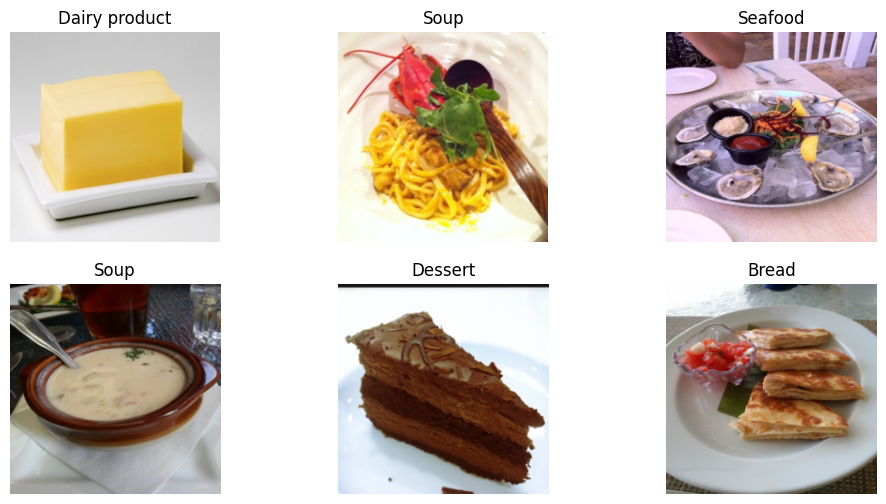

In [7]:
import matplotlib.pyplot as plt

sample_loader = dm.train_dataloader()
images, labels = next(iter(sample_loader))
class_names = dm.class_names

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(class_names[labels[i]])
    plt.axis("off")


## 3. Lightning Module for ViT

In [8]:
class Food11ViTModule(pl.LightningModule):
    def __init__(self, num_classes=11, lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


## 4. Training the Model (with TensorBoard)

In [9]:
logger = TensorBoardLogger("runs", name="food11_vit_no_aug_run", log_graph=False)

trainer = Trainer(
    max_epochs=5,
    logger=logger,
    enable_checkpointing=False,
    log_every_n_steps=100,
    accelerator="auto"
)

# Either train model with or without data augmentation 
# dm = Food11DataModule()
dm = Food11DataModuleNoAug()
dm.setup()

model = Food11ViTModule(num_classes=len(dm.class_names))
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | model     | ViTForImageClassification | 85.8 M | eval 
1 | criterion | CrossEntropyLoss          | 0      | train
----------------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.228   Total estimated model para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Save Model for Hugging Face

In [10]:
model.model.save_pretrained("food11-vit")
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
extractor.save_pretrained("food11-vit")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['food11-vit/preprocessor_config.json']

## 6. Visualize Class Distribution

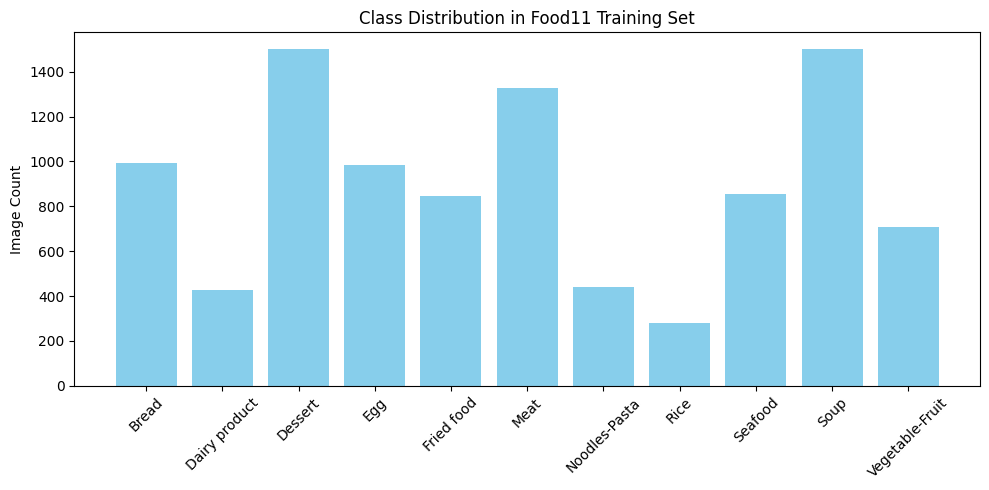

In [11]:
data_dir = "data/food11/training"
classes = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color="skyblue")
plt.xticks(rotation=45)
plt.title("Class Distribution in Food11 Training Set")
plt.ylabel("Image Count")
plt.tight_layout()

os.makedirs("doc", exist_ok=True)
plt.savefig("doc/class_distribution.png")
plt.show()


## 7. Zero-Shot Comparison using CLIP

Device set to use cuda:0



📷 105.jpg
CLIP Prediction: dessert (0.97)
ViT Prediction:  Dessert (1.00)


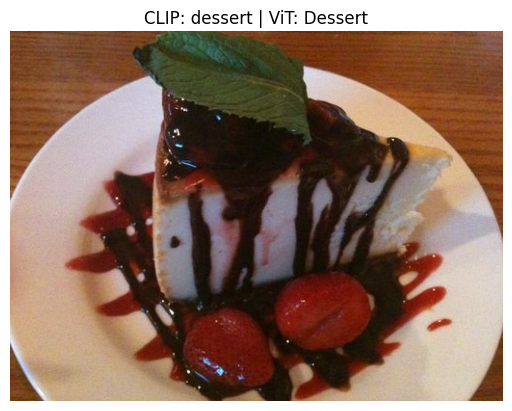


📷 12.jpg
CLIP Prediction: noodles or pasta (0.97)
ViT Prediction:  Noodles-Pasta (1.00)


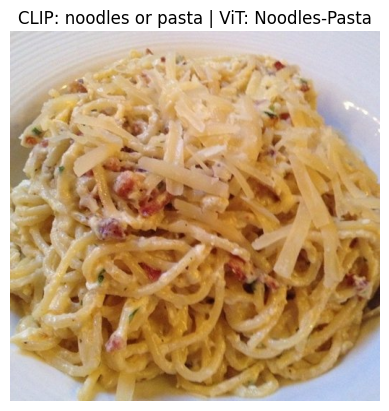


📷 99.jpg
CLIP Prediction: fried food (0.89)
ViT Prediction:  Meat (1.00)


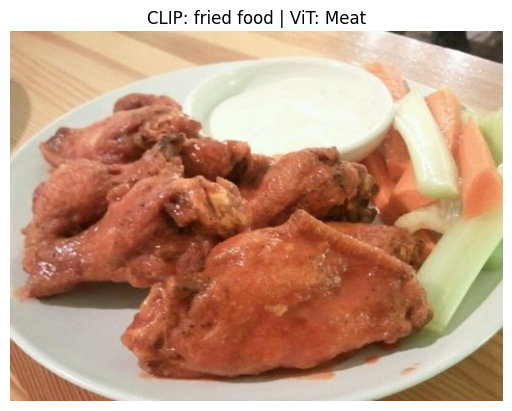

In [15]:
from transformers import pipeline, CLIPProcessor, CLIPModel
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Load your fine-tuned ViT model
vit_classifier = pipeline("image-classification", model="Skorm/food11-vit")

# Labels
candidate_labels = [
    "bread", "dairy product", "dessert", "egg", "fried food",
    "meat", "noodles or pasta", "rice", "seafood", "soup", "vegetables or fruits"
]

# Image paths (choose same images you want in your table!)
image_paths = [
    "data/food11/validation/Dessert/105.jpg",
    "data/food11/validation/Noodles-Pasta/12.jpg",
    "data/food11/validation/Meat/99.jpg"
]

# Run comparison
for path in image_paths:
    if not os.path.exists(path):
        print(f"❌ Not found: {path}")
        continue

    image = Image.open(path)

    # ---- CLIP prediction ----
    clip_inputs = clip_processor(text=candidate_labels, images=image, return_tensors="pt", padding=True)
    clip_outputs = clip_model(**clip_inputs)
    clip_probs = clip_outputs.logits_per_image.softmax(dim=1)[0]

    clip_top_idx = clip_probs.argmax()
    clip_top_label = candidate_labels[clip_top_idx]
    clip_top_score = float(clip_probs[clip_top_idx])

    # ---- ViT fine-tuned prediction ----
    vit_results = vit_classifier(path)
    vit_top_label = vit_results[0]["label"]
    vit_top_score = vit_results[0]["score"]

    # ---- Print comparison ----
    print(f"\n📷 {os.path.basename(path)}")
    print(f"CLIP Prediction: {clip_top_label} ({clip_top_score:.2f})")
    print(f"ViT Prediction:  {vit_top_label} ({vit_top_score:.2f})")

    # Optional: visualize
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"CLIP: {clip_top_label} | ViT: {vit_top_label}")
    plt.show()


### Getting accuracy of Zero Shot Model by testing 50 images of each category

In [ ]:
from tqdm import tqdm 

correct = 0
total = 0

# Map folder names → correct CLIP label
folder_to_label = {
    "Bread": "bread",
    "Dairy product": "dairy product",
    "Dessert": "dessert",
    "Egg": "egg",
    "Fried food": "fried food",
    "Meat": "meat",
    "Noodles-Pasta": "noodles or pasta",
    "Rice": "rice",
    "Seafood": "seafood",
    "Soup": "soup",
    "Vegetable-Fruit": "vegetables or fruits"
}

# Build image list: first 50 images per class
image_list = []

for folder, true_label in folder_to_label.items():
    folder_path = f"data/food11/validation/{folder}"
    files = os.listdir(folder_path)
    files = [f for f in files if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")]
    files = sorted(files)[:50]  # first 50
    for f in files:
        image_path = os.path.join(folder_path, f)
        image_list.append( (image_path, true_label) )

print(f"\nTesting {len(image_list)} images...")

# Loop and run CLIP
for path, true_label in tqdm(image_list):
    if not os.path.exists(path):
        print(f"❌ Not found: {path}")
        continue

    image = Image.open(path).convert("RGB")
    inputs = clip_processor(text=candidate_labels, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)[0]

    clip_top_idx = probs.argmax()
    clip_top_label = candidate_labels[clip_top_idx]

    if clip_top_label == true_label:
        correct += 1
    total += 1

# Final result:
clip_accuracy = (correct / total) * 100
print(f"\n✅ Zero-shot CLIP Accuracy on {total} images: {clip_accuracy:.2f}%")



Testing 550 images...


  0%|          | 0/550 [00:00<?, ?it/s]

100%|██████████| 550/550 [08:31<00:00,  1.07it/s]


✅ Zero-shot CLIP Accuracy on 550 images: 82.36%


## 8. Testing

In [31]:
#Test Logs (run with augmentation)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ea = EventAccumulator("runs/food11_vit/version_2/events.out.tfevents.1748341338.cs-01jw8m1dexj79btbya518rqzrf.1816.0")
ea.Reload()

print("Logged tags:", ea.Tags())
print("Validation Accuracy:", ea.Scalars("val_acc"))

Logged tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss', 'train_acc', 'epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Validation Accuracy: [ScalarEvent(wall_time=1748341699.65581, step=308, value=0.9530612230300903), ScalarEvent(wall_time=1748342065.3503745, step=617, value=0.9620991349220276), ScalarEvent(wall_time=1748342431.2628999, step=926, value=0.9620991349220276), ScalarEvent(wall_time=1748342797.078509, step=1235, value=0.9588921070098877), ScalarEvent(wall_time=1748343163.0145984, step=1544, value=0.9658892154693604)]


In [35]:
train_loss = ea.Scalars("train_loss")
val_loss = ea.Scalars("val_loss")
val_acc = ea.Scalars("val_acc")

for i in range(len(val_loss)):
    print(f"Epoch {i+1} | Step: {val_loss[i].step} | Train Loss: {train_loss[i].value:.4f} | Val Loss: {val_loss[i].value:.4f} | Val Acc: {val_acc[i].value*100:.2f}%")


Epoch 1 | Step: 308 | Train Loss: 1.2517 | Val Loss: 0.1991 | Val Acc: 95.31%
Epoch 2 | Step: 617 | Train Loss: 0.4728 | Val Loss: 0.1376 | Val Acc: 96.21%
Epoch 3 | Step: 926 | Train Loss: 0.2027 | Val Loss: 0.1281 | Val Acc: 96.21%
Epoch 4 | Step: 1235 | Train Loss: 0.2861 | Val Loss: 0.1395 | Val Acc: 95.89%
Epoch 5 | Step: 1544 | Train Loss: 0.2943 | Val Loss: 0.1223 | Val Acc: 96.59%


In [29]:
#Test Logs (run with NO augmentation)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ea_no_aug = EventAccumulator("runs/food11_vit_no_aug_run/version_0/events.out.tfevents.1748855875.cs-01jwqxqdmxvpaj2t1n13adg1qn.1715.0")
ea_no_aug.Reload()

print("Logged tags:", ea_no_aug.Tags())
print("Validation Accuracy:", ea_no_aug.Scalars("val_acc"))

Logged tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss_step', 'train_acc_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc_epoch'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Validation Accuracy: [ScalarEvent(wall_time=1748856231.5917938, step=308, value=0.9568513035774231), ScalarEvent(wall_time=1748856591.1998646, step=617, value=0.9644314646720886), ScalarEvent(wall_time=1748856950.4722075, step=926, value=0.962390661239624), ScalarEvent(wall_time=1748857309.4353004, step=1235, value=0.9612244963645935), ScalarEvent(wall_time=1748857669.030547, step=1544, value=0.9586005806922913)]


In [30]:
train_loss = ea_no_aug.Scalars("train_loss_epoch")
val_loss = ea_no_aug.Scalars("val_loss")
val_acc = ea_no_aug.Scalars("val_acc")

for i in range(len(val_loss)):
    print(f"Epoch {i+1} | Step: {val_loss[i].step} | Train Loss: {train_loss[i].value:.4f} | Val Loss: {val_loss[i].value:.4f} | Val Acc: {val_acc[i].value*100:.2f}%")


Epoch 1 | Step: 308 | Train Loss: 0.5696 | Val Loss: 0.1847 | Val Acc: 95.69%
Epoch 2 | Step: 617 | Train Loss: 0.0726 | Val Loss: 0.1346 | Val Acc: 96.44%
Epoch 3 | Step: 926 | Train Loss: 0.0193 | Val Loss: 0.1290 | Val Acc: 96.24%
Epoch 4 | Step: 1235 | Train Loss: 0.0072 | Val Loss: 0.1313 | Val Acc: 96.12%
Epoch 5 | Step: 1544 | Train Loss: 0.0035 | Val Loss: 0.1395 | Val Acc: 95.86%
